# Прогнозирование уровня средней заработной платы в России

В данной работе необходимо проанализировать данные о среднемесячной заработной плате в Росии, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [1]:
#Загружаем модули и создаем функцию для обратного преобразования Бокса-Кокса

%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
#загружаем данные
wage = pd.read_csv('monthly_wage.csv', delimiter = ';', index_col = 'month')
wage.columns = ['Wage']

In [3]:
#Просмотрим данные
wage.head()

,Wage
month,
01.01.1993,15.3
01.02.1993,19.1
01.03.1993,23.6
01.04.1993,30.6
01.05.1993,37.5


Далее визуализируем исследуемый ряд, посмотрим, имеет ли он ярко выраженный тренд, сезонность или циклы

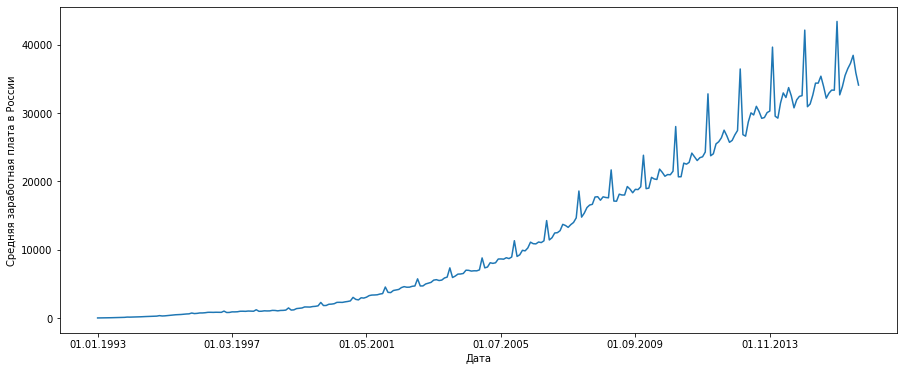

In [4]:
plt.figure(figsize(15,6))
wage['Wage'].plot()
plt.ylabel('Средняя заработная плата в России')
plt.xlabel('Дата')
pylab.show()

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

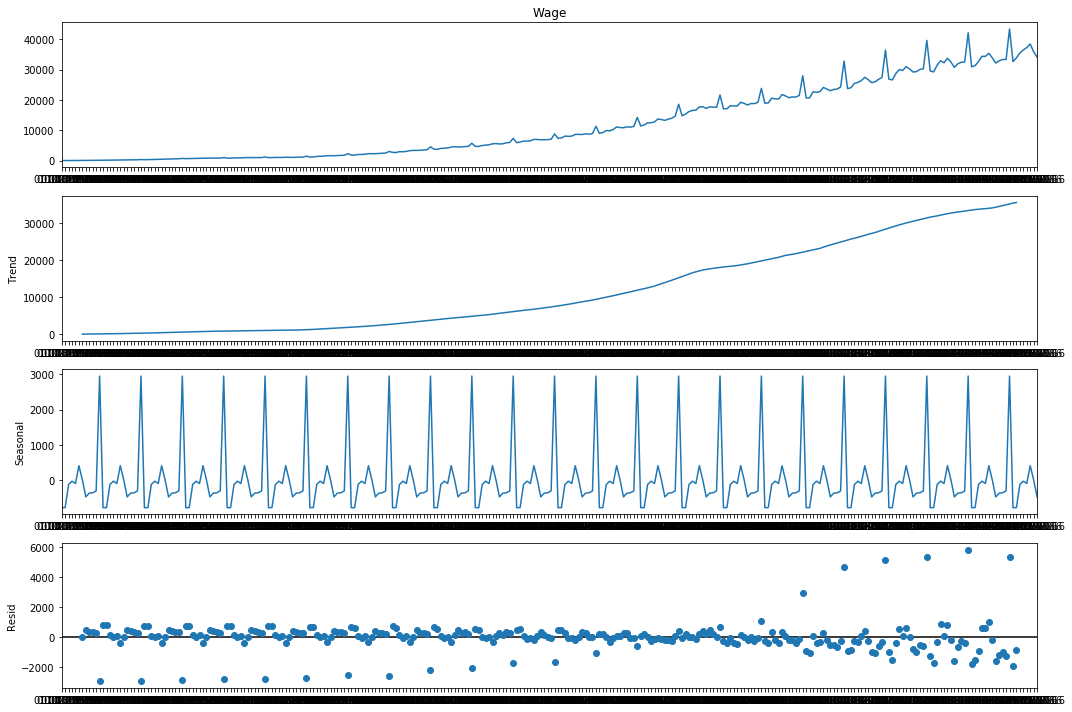

In [5]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage['Wage'], period = 12).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage['Wage'])[1])

Как мы видим, данный ряд имеет ярко выраженный повышающий тренд, так же хорошо видна годовая сезонность. Также стоит отметить, что ряд имеет изменяющуюся во времени дисперсию - ближе к концу ряда разность средних зарплат в соседние месяцы может достигать 5-7 тясяч, тогда же, как в начале ряда целевой параметр исследования имеет очень малый разброс. Востатках также хорошо заметна структура. Ряд крайне далёк от стационарного.

Раз ряд не имеет постоянной дисперсии, первым делом нам нужно стабилизировать ее. Для этого применим преобразование Бокса-Кокса.

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


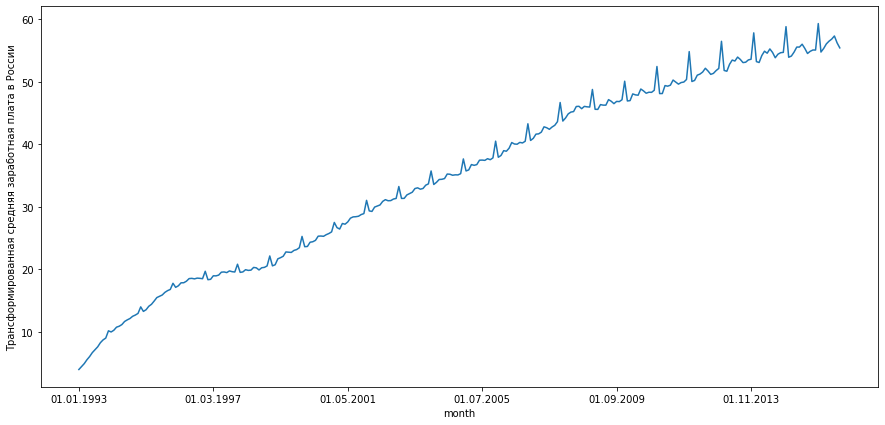

In [6]:
wage['Wage'], lmbda = stats.boxcox(wage['Wage'])
plt.figure(figsize(15,7))
wage['Wage'].plot()
plt.ylabel(u'Трансформированная средняя заработная плата в России')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage['Wage'])[1])

Как мы видим, ряд всё еще не обладает постоянной дисперсией, однако разброс, безусловно, уменьшился. 

Далее постараемся привести ряд к стационарному виду, для этого будем использовать сезонное и обычное дифференцирование ряда.

Критерий Дики-Фуллера: p=0.007364


<Figure size 1080x720 with 0 Axes>

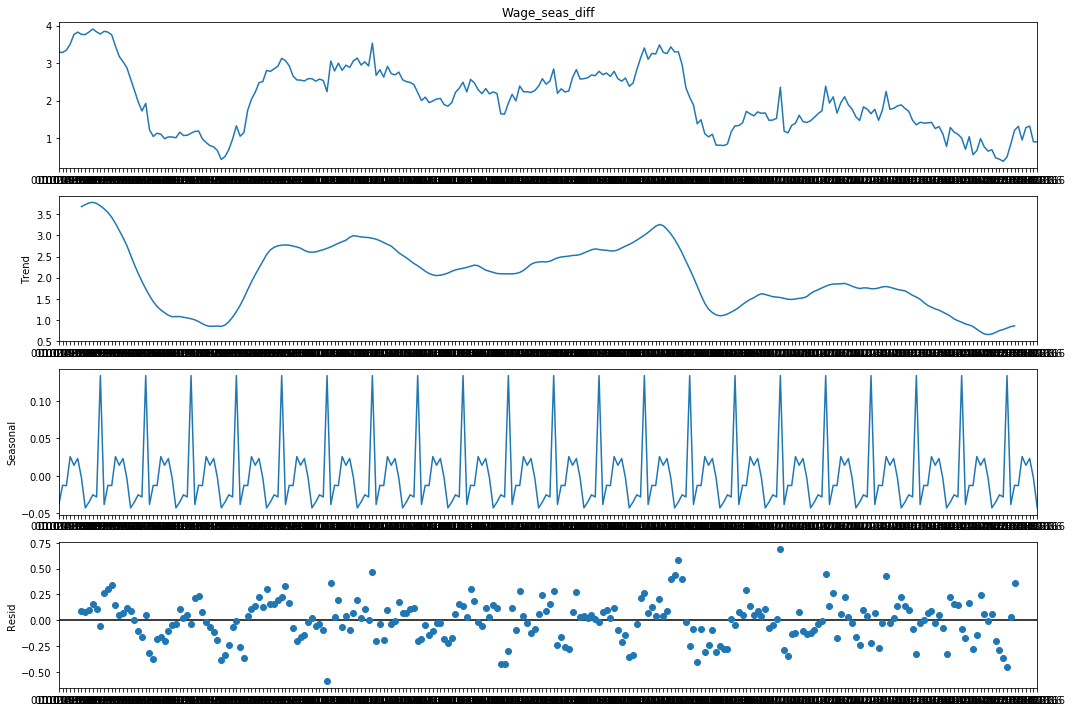

In [7]:
wage['Wage_seas_diff'] = wage['Wage'] - wage['Wage'].shift(12)    #Производим сезонное дифференцирование
                                                                    #Период сезона - 12
wage.dropna(inplace = True)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage['Wage_seas_diff'][12:], period=12).plot()    #Вновь построим STL-декомпозицию
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage['Wage_seas_diff'][12:])[1])

In [8]:
wage

,Wage,Wage_seas_diff
month,,
01.01.1994,9.996196,6.005802
01.02.1994,10.272455,5.813697
01.03.1994,10.762540,5.830905
01.04.1994,10.916080,5.366650
01.05.1994,11.180371,5.116965
...,...,...
01.04.2016,56.526742,0.942729
01.05.2016,56.860441,1.275065
01.06.2016,57.358885,1.316994


Значение p-value меньше 0.05, так что можно считать, что критерий Дики-Фуллера отвергает гипотезу нестационарности. Нам удалось убрать тренд, однако сезонность всё ещё прослеживается. Так что, попробуем добавить к сезонному дифференцирование одно обычное.

Критерий Дики-Фуллера: p=0.000001


<Figure size 1080x720 with 0 Axes>

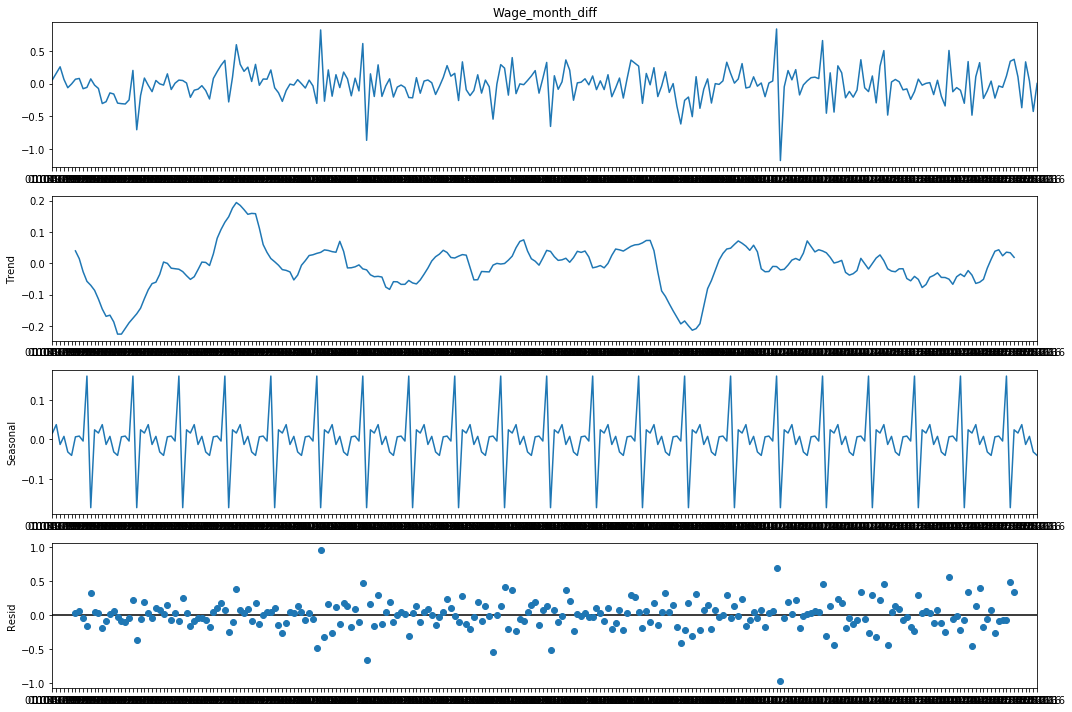

In [9]:
wage['Wage_month_diff'] = wage['Wage_seas_diff'] - wage['Wage_seas_diff'].shift(1)    #Производим сезонное дифференцирование
                                                                                        #Период сезона - 12
wage.dropna(inplace = True)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage['Wage_month_diff'][13:], period=12).plot()    #Вновь построим STL-декомпозицию
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage['Wage_month_diff'][13:])[1])

Нам удалось избавиться от сезонности, тренд так же стал совсем неразличим. Значение критерия Дики-Фуллера ещё больше уменьшилось. Теперь ряд точно стационарен. В дальнейшем будем использовать ряд, полученный с d = 1 и D = 1.

Далее займёмся подбором параметров модели SARIMA, начнём с p,P,q,Q. Сначала построим автокорелляционную функцию, по которой выберем q и Q.

In [10]:
wage

,Wage,Wage_seas_diff,Wage_month_diff
month,,,
01.02.1994,10.272455,5.813697,-0.192106
01.03.1994,10.762540,5.830905,0.017208
01.04.1994,10.916080,5.366650,-0.464255
01.05.1994,11.180371,5.116965,-0.249685
01.06.1994,11.672918,4.982199,-0.134766
...,...,...,...
01.04.2016,56.526742,0.942729,-0.366210
01.05.2016,56.860441,1.275065,0.332336
01.06.2016,57.358885,1.316994,0.041929


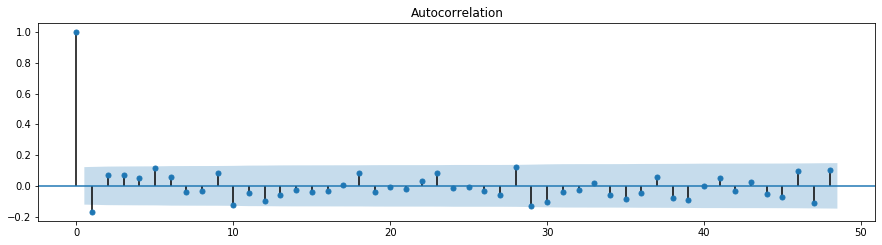

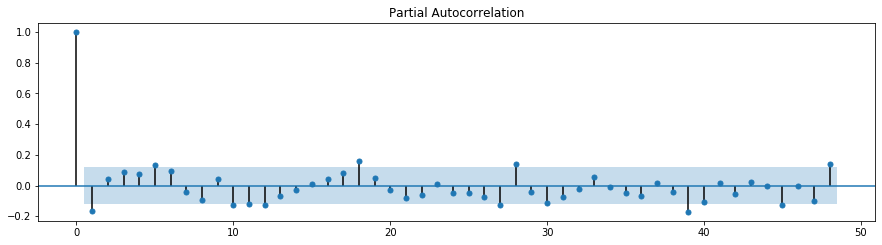

In [11]:
#Строим график автокорреляции 
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage['Wage_month_diff'][13:].values.squeeze(), lags=48, ax=ax)

#Строим частичную автокорреляцию
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage['Wage_month_diff'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

На графике автокорреляции нет значимых сезонных лагов, поэтому Q = 0. В пределах первого сезона видны 2 значимых несезонных лага - 1 и 10. Чтобы не увеличивать количество компонент в модели SARIMA выберем q = 1. На графике частичной автокорреляционной функции видны 2 значимых сезонных лага - это лаги под номерами 12 и 48. Более правильным является выбор последнего значимого сезонного лага, к тому же в данном случае это не так уж сильно увеличит количество компонент в разложении каждого прогноза, поэтому выбираем P = 4. Значимых несезонных лагов в пределах первого периода таже несколько - первый, пятый, десятый и одиннадцатый. Взять 10 или 11 - значит серьезно усложнить модель в отношении количества компонент, которыми описывается каждый прогноз. Среди p=5 и p=1 выберем p=5 (Изначально я выбрал p = 1, затем провел обучение с начальным приближением p = 5, и в последнем случае результат оказался лучше).

In [12]:
print(f'Начальные приближения системы: Q = 0, q = 1, P = 4, p = 5')

Начальные приближения системы: Q = 0, q = 1, P = 4, p = 5


In [13]:
#Определяем все возможные параметры модели

ps = range(0, 6)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

#составляем все возможные комбинации параметров
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(f'Количество возможных комбинаций параметров модели: {len(parameters_list)}')

Количество возможных комбинаций параметров модели: 60


In [14]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wage['Wage'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 3min 7s


In [15]:
#Просмотрим лучшие модели

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
56  (5, 1, 1, 0) -5.291281
36  (3, 1, 1, 0) -5.285764
51  (5, 0, 1, 0) -5.002078
26  (2, 1, 1, 0) -4.418950
46  (4, 1, 1, 0) -4.268793


Просмотрим подробную информацию о лучшей модели.

In [16]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                Wage   No. Observations:                  271
Model:             SARIMAX(5, 1, 1)x(1, 1, [], 12)   Log Likelihood                  10.646
Date:                             Sun, 06 Dec 2020   AIC                             -5.291
Time:                                     23:14:07   BIC                             23.132
Sample:                                          0   HQIC                             6.138
                                             - 271                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1692      0.486      0.348      0.728      -0.783       1.122
ar.L2          0.0867      

Итак, лучшей моделью оказалась модель SARIMAX(5,1,1)х(1,1,0). Для нее достигается наименьшее значение информационного критерия Акаике.

Теперь проведем анализ остатков модели. Если ряд остатков будет стационарен и неавтокоррелирован, значит, модель вполне можно принять, как действующую.

Критерий Стьюдента: p=0.606722
Критерий Дики-Фуллера: p=0.000000


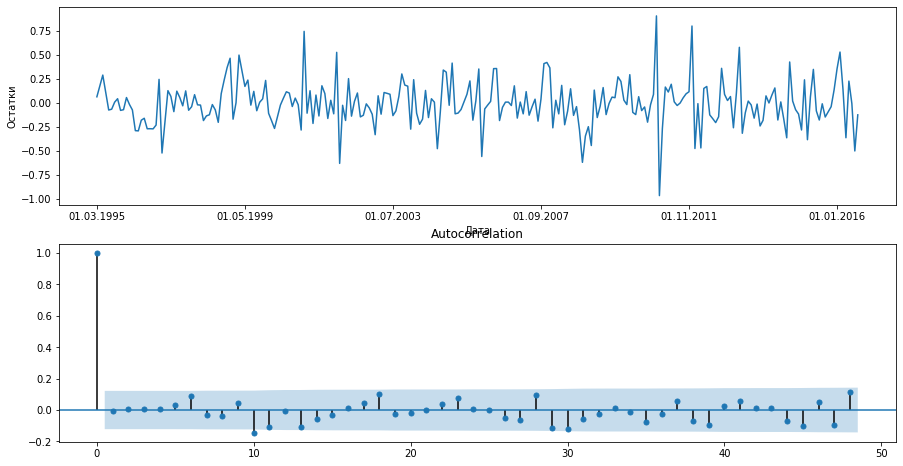

In [17]:
plt.figure(figsize(15,8))
plt.subplot(211)

#Изображаем на графике остатки лучшей модели.
best_model.resid[13:].plot()
plt.ylabel(u'Остатки')
plt.xlabel(u'Дата')

#Выводим коррелограмму остатков
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

Судя по графикам, остатки несмещены, т.к. все остатки располагаются около нуля, дисперсия остатков примерно постоянна(в том смысле, что нет определенной зависимости дисперсии остатков от времени), а очень малое значение критерия Дики-Фуллера подтверждает стационарность ряда остатков. Также, ряд неавтокореллирован, судя по коррелограмме, ибо на ней нет значимых сезонных лагов, есть только один несезонный.

In [18]:
untouched_wage = pd.read_csv('monthly_wage.csv', delimiter = ';', index_col = 'month')
untouched_wage.columns = ['Wage']

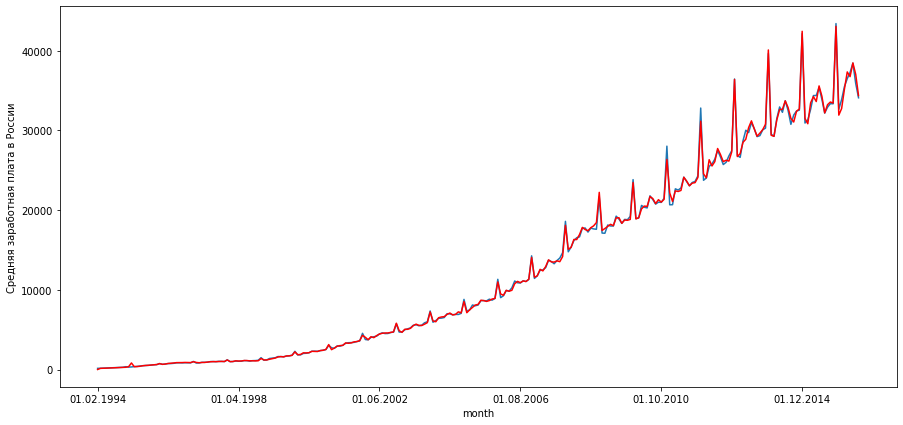

In [19]:
wage['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
untouched_wage['Wage'][13:].plot()
wage['model'].plot(color='r')
plt.ylabel('Средняя заработная плата в России')
pylab.show()

In [106]:
data = pd.read_csv('monthly_wage.csv', sep = ';', index_col = 'month', parse_dates=True, dayfirst=True)
data.rename(columns = {'WAG_C_M': 'wage'}, inplace = True)

In [96]:
print(type(data2))

<class 'pandas.core.frame.DataFrame'>


In [199]:
index = pd.date_range(start='1993-01-01', periods=308, freq='MS')
print(index)

DatetimeIndex(['1993-01-01', '1993-02-01', '1993-03-01', '1993-04-01',
               '1993-05-01', '1993-06-01', '1993-07-01', '1993-08-01',
               '1993-09-01', '1993-10-01',
               ...
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01'],
              dtype='datetime64[ns]', length=308, freq='MS')
1993-01-01   NaN
1993-02-01   NaN
1993-03-01   NaN
1993-04-01   NaN
1993-05-01   NaN
              ..
2018-04-01   NaN
2018-05-01   NaN
2018-06-01   NaN
2018-07-01   NaN
2018-08-01   NaN
Freq: MS, Name: Wage, Length: 308, dtype: float64


In [113]:
test = pd.read_csv('monthly_wage.csv', sep = ';', index_col = 'month', parse_dates=True, dayfirst=True)
test.rename(columns = {'WAG_C_M': 'wage'}, inplace = True)

test['wage'], lmbda = stats.boxcox(test['wage'])

In [114]:
pepe_model=sm.tsa.statespace.SARIMAX(test['wage'][13:], order=(5, 1, 1), 
                                        seasonal_order=(1, 1, 0, 12)).fit(disp=-1)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [234]:
pepega_wages = (invboxcox(pepe_model.forecast(24), lmbda))
pepega_wages = pd.DataFrame(data = pepega_wages.values, columns = ['wage'])
pepega_wages.index = index[-24:]
print(pepega_wages)

                    wage
2016-09-01  34919.927143
2016-10-01  35417.003045
2016-11-01  35364.644363
2016-12-01  45643.924545
2017-01-01  34339.630537
2017-02-01  35451.459630
2017-03-01  37078.110882
2017-04-01  38209.923268
2017-05-01  38861.288614
2017-06-01  40045.144069
2017-07-01  37543.599700
2017-08-01  35678.861037
2017-09-01  36513.866564
2017-10-01  37014.778573
2017-11-01  36961.559931
2017-12-01  47595.831944
2018-01-01  35941.336684
2018-02-01  37110.223854
2018-03-01  38798.167515
2018-04-01  39950.098639
2018-05-01  40644.008165
2018-06-01  41870.474908
2018-07-01  39262.490329
2018-08-01  37335.463013


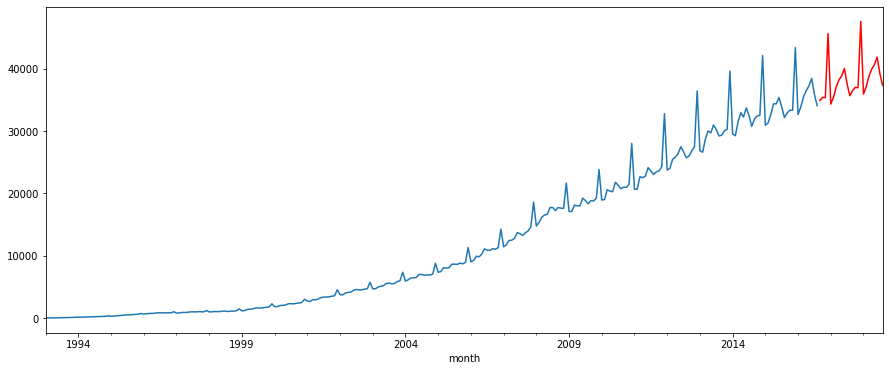

In [235]:
plt.figure(figsize(15,6))
data['wage'].plot()
pepega_wages['wage'].plot(color = 'r')
plt.show()